<a href="https://colab.research.google.com/github/noobg0d/PJT/blob/main/Pjt2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('ggplot')

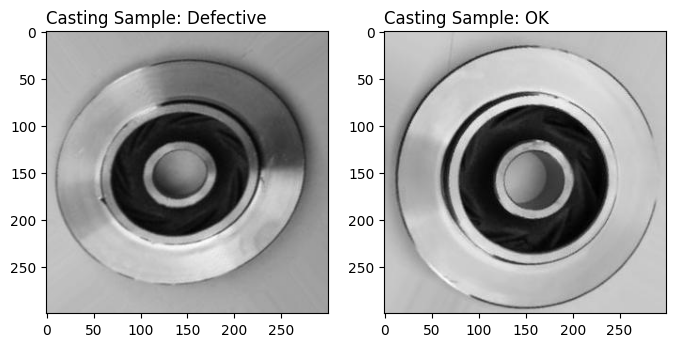

In [2]:
import os
import matplotlib.pyplot as plt

# Update the directory paths to point to Google Drive
dir_train = '/content/drive/MyDrive/casting_data/train'
dir_train_def = os.path.join(dir_train, 'def_front')  # Class label: Defective
dir_train_ok = os.path.join(dir_train, 'ok_front')    # Class label: OK

# Specify directory of test data
dir_test = '/content/drive/MyDrive/casting_data/test'
dir_test_def = os.path.join(dir_test, 'def_front')
dir_test_ok = os.path.join(dir_test, 'ok_front')

dir_val = '/content/drive/MyDrive/casting_data/validation'
dir_val_def = os.path.join(dir_val, 'def_front')
dir_val_ok = os.path.join(dir_val, 'ok_front')

# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sample_def = plt.imread(os.path.join(dir_train_def, os.listdir(dir_train_def)[0]))
sample_ok = plt.imread(os.path.join(dir_train_ok, os.listdir(dir_train_ok)[0]))
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


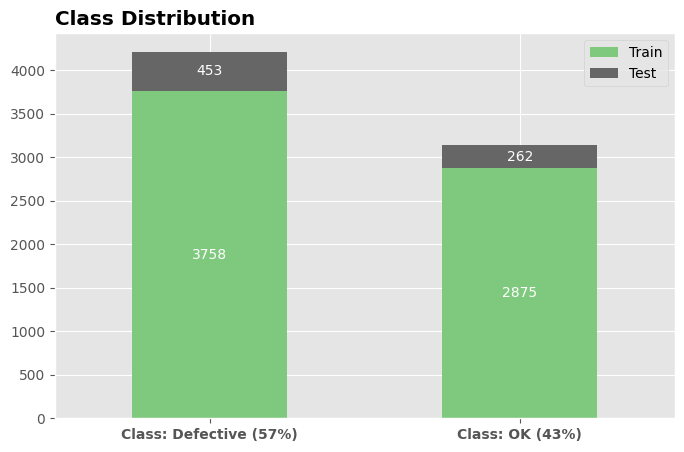

In [5]:
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25,
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()


In [6]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [7]:
cnn_model = Sequential([
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,
           input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')        # Only 1 output
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [8]:
n_epochs = 20
cnn_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=n_epochs,
    callbacks=ModelCheckpoint(
        'CNN_Casting_Inspection.hdf5',
        save_best_only=True,
        monitor='val_loss'),
    verbose=1)

Epoch 1/20
83/83 [==============================] - 2344s 29s/step - loss: 0.6801 - accuracy: 0.5700 - val_loss: 0.5666 - val_accuracy: 0.7624
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 145s 2s/step - loss: 0.5039 - accuracy: 0.7445 - val_loss: 0.4211 - val_accuracy: 0.7971
Epoch 3/20
83/83 [==============================] - 132s 2s/step - loss: 0.3459 - accuracy: 0.8510 - val_loss: 0.2824 - val_accuracy: 0.8718
Epoch 4/20
83/83 [==============================] - 135s 2s/step - loss: 0.2842 - accuracy: 0.8813 - val_loss: 0.2165 - val_accuracy: 0.9291
Epoch 5/20
83/83 [==============================] - 134s 2s/step - loss: 0.2206 - accuracy: 0.9128 - val_loss: 0.2017 - val_accuracy: 0.9095
Epoch 6/20
83/83 [==============================] - 142s 2s/step - loss: 0.1546 - accuracy: 0.9442 - val_loss: 0.1275 - val_accuracy: 0.9578
Epoch 7/20
83/83 [==============================] - 138s 2s/step - loss: 0.1176 - accuracy: 0.9597 - val_loss: 0.0988 - val_accuracy: 0.9691
Epoch 8/20
83/83 [==============================] - 145s 2s/step - loss: 0.0939 - accuracy: 0.9693 - val_loss: 0.0811 - val_accuracy: 0.9759
Epoch 9/20
83/83 [======

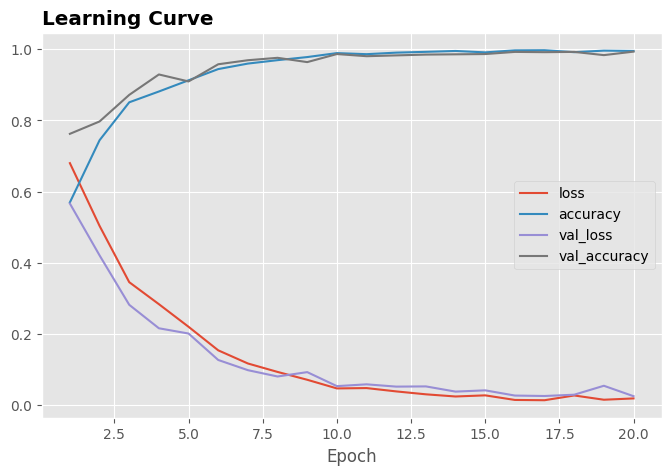

In [9]:
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

In [10]:
best_model = load_model('./CNN_Casting_Inspection.hdf5')

# Make predictions on images in the test set
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

12/12 [==============================] - 229s 21s/step


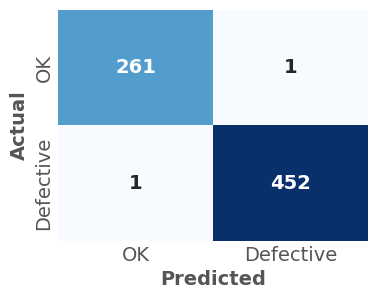

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [12]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9962    0.9962    0.9962       262
           1     0.9978    0.9978    0.9978       453

    accuracy                         0.9972       715
   macro avg     0.9970    0.9970    0.9970       715
weighted avg     0.9972    0.9972    0.9972       715



1/1 [==============================] - 0s 28ms/step


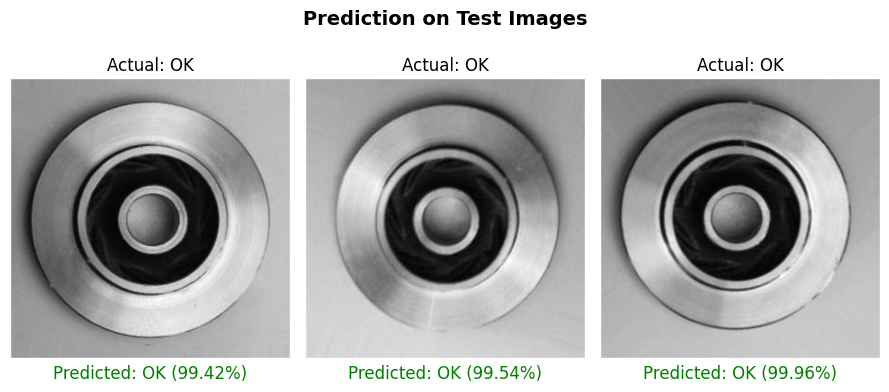

In [13]:
class_map = {0: 'OK', 1: 'Defective'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', y=0.98, weight='bold', size=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 38ms/step


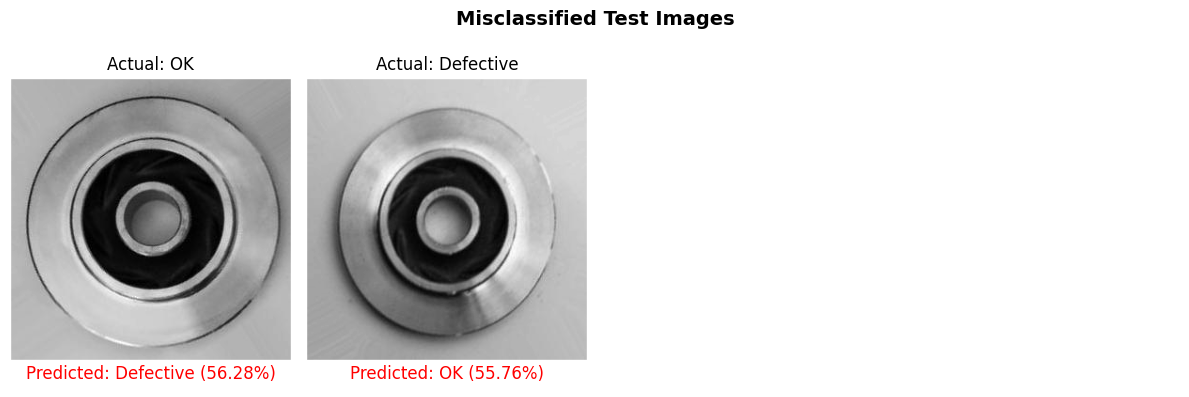

In [17]:
# Find the indices of misclassified images
misclassified = np.nonzero(y_pred != y_true)[0]

# Calculate batch number and image number within the batch
batch_num = misclassified // batch_size
image_num = misclassified % batch_size

# Prepare the figure
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Misclassified Test Images', y=0.98, weight='bold', size=14)

# Loop through the axes and the misclassified images
for ax in axes.flat:
    if batch_num.size > 0:
        bnum = batch_num[0]
        inum = image_num[0]
        batch_num = batch_num[1:]
        image_num = image_num[1:]

        images, labels = test_set[bnum]
        img = images[inum]
        ax.imshow(img.reshape(*img_size), cmap='gray')

        [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
        pred_label = class_map[int(pred_prob >= 0.5)]
        true_label = class_map[labels[inum]]
        prob_class = 100 * pred_prob if pred_label == 'Defective' else 100 * (1 - pred_prob)

        ax.set_title(f'Actual: {true_label}', size=12)
        ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                      color='g' if pred_label == true_label else 'r')
    else:
        # If there are no more misclassified images, turn off the axis
        ax.axis('off')

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the path to the folder containing the result images
result_folder = r"/content/drive/MyDrive/pjt project dataset/resultt"

# Create a function to load and preprocess the images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Create a function to predict if the object is defective or not
def predict_defect(img_array):
    [[pred_prob]] = best_model.predict(img_array)
    pred_label = class_map[int(pred_prob >= 0.5)]
    prob_class = 100 * pred_prob if pred_label == 'Defective' else 100 * (1 - pred_prob)
    return pred_label, prob_class

# Prepare the output file to save the results
output_file = 'prediction_results.txt'
with open(output_file, 'w') as f:
    f.write('Image\tPrediction\tProbability(%)\n')

    # Loop through the images in the result folder
    for img_name in os.listdir(result_folder):
        img_path = os.path.join(result_folder, img_name)
        if img_path.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
            img_array = load_and_preprocess_image(img_path)
            pred_label, prob_class = predict_defect(img_array)

            # Write the result to the output file
            f.write(f'{img_name}\t{pred_label}\t{prob_class:.2f}\n')

print(f'Predictions saved to {output_file}')


1/1 [==============================] - 0s 25ms/step
Predictions saved to prediction_results.txt


1/1 [==============================] - 0s 25ms/step


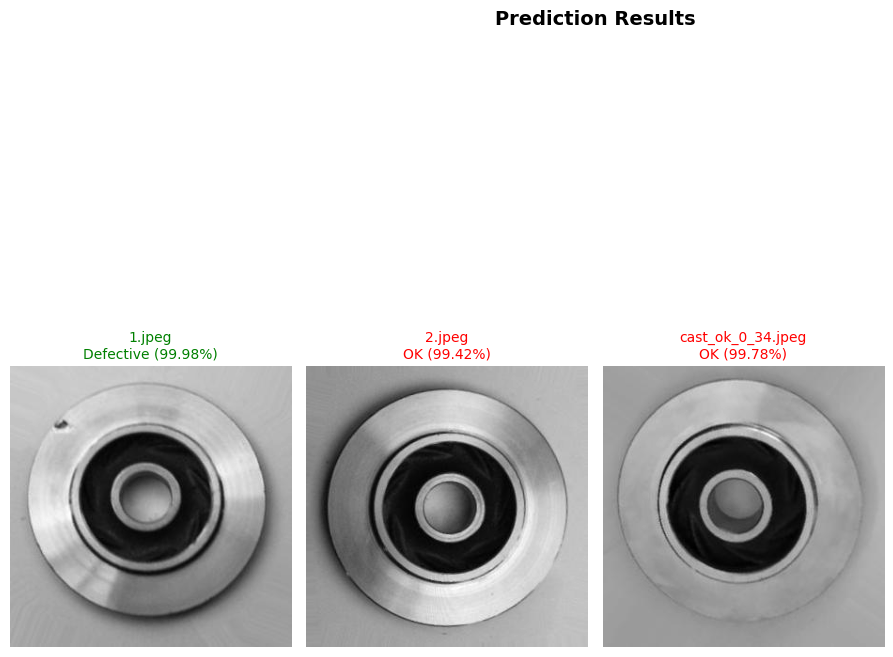

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the path to the folder containing the result images
result_folder =  r"/content/drive/MyDrive/pjt project dataset/resultt"

# Create a function to load and preprocess the images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Create a function to predict if the object is defective or not
def predict_defect(img_array):
    [[pred_prob]] = best_model.predict(img_array)
    pred_label = class_map[int(pred_prob >= 0.5)]
    prob_class = 100 * pred_prob if pred_label == 'Defective' else 100 * (1 - pred_prob)
    return pred_label, prob_class

# Prepare to display the results
plt.figure(figsize=(12, 12))
plt.suptitle('Prediction Results', y=0.9, weight='bold', size=14)

# Loop through the images in the result folder and display them
image_files = [f for f in os.listdir(result_folder) if f.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
num_images = len(image_files)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed

for idx, img_name in enumerate(image_files):
    img_path = os.path.join(result_folder, img_name)
    img_array = load_and_preprocess_image(img_path)
    pred_label, prob_class = predict_defect(img_array)

    plt.subplot(num_rows, num_cols, idx + 1)
    img_display = image.load_img(img_path, target_size=img_size, color_mode='grayscale')
    plt.imshow(img_display, cmap='gray')
    plt.title(f'{img_name}\n{pred_label} ({prob_class:.2f}%)',
              color='g' if pred_label == 'Defective' else 'r', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
